In [2]:
df <- load("/Users/randall/Downloads/ChromeDownload/BookClub-master/AppliedPredictiveModeling/references/grant_Data.Rdata")
#remove zear var cols first before scaling
ZeroVarCol <- c("Sponsor260D","Sponsor281A" , "Sponsor315C")
fullSet <- fullSet[! fullSet %in% ZeroVarCol]

In [3]:
str(df)

 chr [1:5] "training" "testing" "pre2008" "fullSet" "reducedSet"


`Nonlinear Discriminant Analysis`

In [5]:
library(doMC)
registerDoMC(12)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [6]:
# install.packages("mda")
library(mda)
fit_mda <- mda(Class~.,
               data=training[pre2008,c(reducedSet,"Class")],
               subclass=3)

Loading required package: class
Loaded mda 0.4-10



In [7]:
fit_mda

Call:
mda(formula = Class ~ ., data = training[pre2008, c(reducedSet, 
    "Class")], subclasses = 3)

Dimension: 5 

Percent Between-Group Variance Explained:
    v1     v2     v3     v4     v5 
 72.50  92.57  96.10  98.66 100.00 

Degrees of Freedom (per dimension): 253 

Training Misclassification Error: 0.18709 ( N = 6633 )

Deviance: 6429.499 

In [10]:
library(caret)
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)
set.seed(476)
mda_fit <- train(training[,reducedSet],training$Class,
                method="mda",metric="ROC",
                tuneGrid=expand.grid(subclasses=1:8),
                trControl=ctrl)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

In [11]:
mda_fit

Mixture Discriminant Analysis 

8190 samples
 252 predictor
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results across tuning parameters:

  subclasses  ROC        Sens       Spec     
  1           0.8874473  0.8105263  0.8216819
  2           0.8650118  0.7894737  0.8125633
  3           0.8312092  0.8350877  0.7264438
  4           0.8469845  0.8614035  0.7082067
  5           0.8417107  0.8947368  0.6676798
  6           0.4337884        NaN        NaN
  7           0.4337884        NaN        NaN
  8           0.8246716  0.8315789  0.7132725

ROC was used to select the optimal model using  the largest value.
The final value used for the model was subclasses = 1.

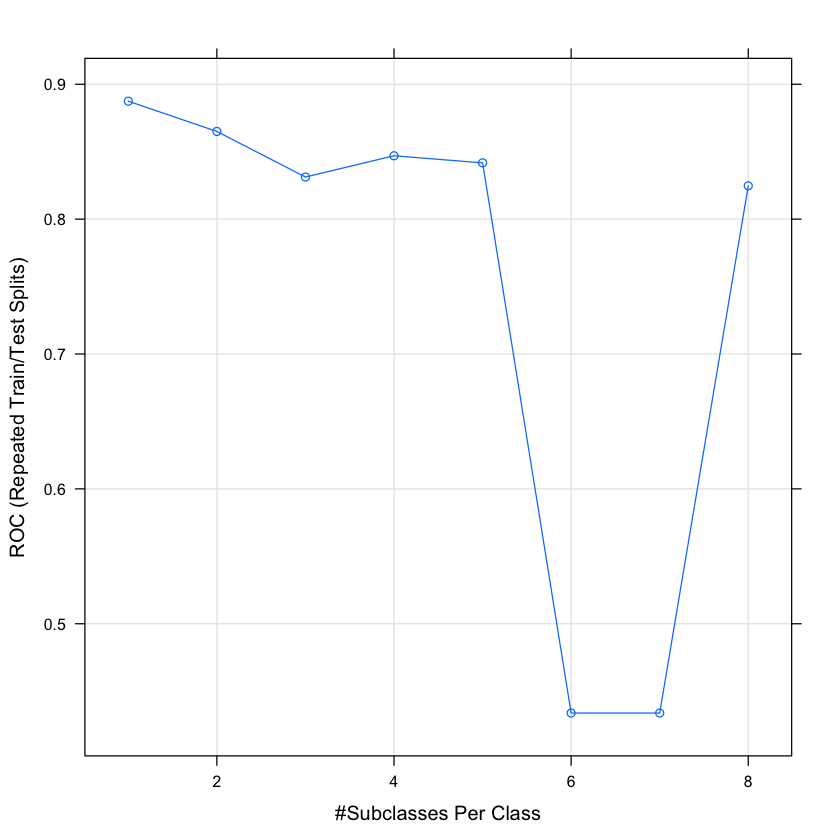

In [12]:
plot(mda_fit)

```r
### Section 13.1 Nonlinear Discriminant Analysis


load("grantData.RData")

library(caret)

### Optional: parallel processing can be used via the 'do' packages,
### such as doMC, doMPI etc. We used doMC (not on Windows) to speed
### up the computations.
 
### WARNING: Be aware of how much memory is needed to parallel
### process. It can very quickly overwhelm the available hardware. We
### estimate the memory usage (VSIZE = total memory size) to be 
### 2700M/core.

library(doMC)
registerDoMC(12)

## This control object will be used across multiple models so that the
## data splitting is consistent

ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)

set.seed(476)
mdaFit <- train(x = training[,reducedSet], 
                y = training$Class,
                method = "mda",
                metric = "ROC",
                tries = 40,
                tuneGrid = expand.grid(subclasses = 1:8),
                trControl = ctrl)
mdaFit

mdaFit$results <- mdaFit$results[!is.na(mdaFit$results$ROC),]                
mdaFit$pred <- merge(mdaFit$pred,  mdaFit$bestTune)
mdaCM <- confusionMatrix(mdaFit, norm = "none")
mdaCM

mdaRoc <- roc(response = mdaFit$pred$obs,
              predictor = mdaFit$pred$successful,
              levels = rev(levels(mdaFit$pred$obs)))
mdaRoc

update(plot(mdaFit,
            ylab = "ROC AUC (2008 Hold-Out Data)"))
```